# Protein language model training

This notebook trains the language models for applying ULMFit to protein sequences. The dataproc notebook should be run first to create some datasets.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Import libraries:

In [2]:
from fastai import *
from fastai.text import *

import pickle

sys.path.append("..")
import readseq
import ulmputils

seqDirPath = Config().data_path()/'pseq'
ulmputils.modelDirPath = modelDirPath = seqDirPath/'models'

In [3]:
print(ulmputils.vocab.itos)

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'xxfake', 'xxfake', 'xxfake']


### Create and save databunches for training language models:

In [4]:
bs = 64
def getDataLm(lmFName) :
    lmFullFName = lmFName+'_lm.pkl'
    if not (seqDirPath/lmFullFName).exists() :
        l = TextList.from_csv(seqDirPath,lmFName+'.csv', cols='sequence',
                          processor=ulmputils.processor)
        print(l[0])
        ulmputils.randomSeedForTraining(3141)
        dataLm = l.split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs)
        dataLm.save(lmFullFName)
    else :
        dataLm = load_data(seqDirPath, lmFullFName, bs=bs)
    return dataLm

In [5]:
dataLm = getDataLm('swissprotPE3AA20AllP')
print(dataLm.train_ds[0])
dataLm.show_batch()
dataLm = None

(Text xxbos A D T I V A V E L D T Y P N T D I G D P S Y P H I G I D I K S V R S K K T A K W N M Q N G K V G T A H I I Y N S V G K R L S A V V S Y P N G D S A T V S Y D V D L D N V L P E W V R V G L S A T T G L Y K E T N T I L S W S F T S K L K S N S T H E T N A L H F M F N Q F S K D Q K D L I L Q G D A T T G R D G N L E L T R V S S N G S P Q G S S V G R A L F Y A P V H I W E S S A V V A S F D A T F T F L I K S S D S H P A D G I A F F I S N I D S S I P S G S T G R L L G L F P D A N, EmptyLabel )


idx,text
0,G D S A T V S Y D V D L D N V L P E W V R V G L S A T T G L Y K E T N T I L S W S F T S K L K S N S T H E T N A L H F M F N Q F S K D Q K D
1,A M T I A T A A L F A K G T T T L R N I Y N W R V K E T D R L F A M A T E L R K V G A E V E E G H D F I R I T P P E K L K F A E I A T Y N D
2,V G D V I A A L G R D N G W S G L I I N G A V R D A S T L R T L D I G I K A L G T N P R K S T K T G A G E R D V P V D F G G V T F T P G D V
3,S V A E R S F I K A L N G G C S S P S A A Y G V I Q G E K I V L T G F Y V D K N G K I Y K M T K T G D R N Q G E A L G Y S L A M E M L K G A
4,L F I V N D R L D I A L A T G A D G V H L G Q D D L P A T V A R K L L G P D R I I G V S T G T R E E A L Q A E K E G A D Y V G F G H I F P T


### Set up hyperparameters for training language models:

In [6]:
# tried
# qrnn=True - unable to run (CUDA_HOME undefined)
print(awd_lstm_lm_config)
lmPars = dict(awd_lstm_lm_config,
    emb_sz = 400,
    n_hid = 1152,
    n_layers = 3,
    qrnn = False,
)
archPars = dict(
    drop_mult=0.2,
)

{'emb_sz': 400, 'n_hid': 1152, 'n_layers': 3, 'pad_token': 1, 'qrnn': False, 'bidir': False, 'output_p': 0.1, 'hidden_p': 0.15, 'input_p': 0.25, 'embed_p': 0.02, 'weight_p': 0.2, 'tie_weights': True, 'out_bias': True}


### Create, train and save language models:
Starting with the big non-transmembrane dataset loaded above.

In [9]:
def setupLmTraining(withPref=None, withLmFName=None, withLmPars=None, withArchPars=None,
                    seed=3141, printInfo=False) :
    global pref, lmFName, lmPars, archPars, dataLm, learn, modelFName
    if withPref is not None : pref = withPref
    if withLmFName is not None : lmFName = withLmFName
    if withLmPars is not None : lmPars = withLmPars
    if withArchPars is not None : archPars = withArchPars
    dataLm = getDataLm(lmFName)
    if seed is not None :
        ulmputils.randomSeedForTraining(seed)
    learn = language_model_learner(dataLm, AWD_LSTM, config=lmPars,
                                   pretrained=False, **archPars)
    if printInfo :
        print(learn.data.bptt)
        print(learn.model)
    modelFName = ulmputils.getModelFNameFromHyperPars(pref+'_'+lmFName,
                                            (lmPars,awd_lstm_lm_config),archPars)
    ulmputils.loadLatestModelVersion(learn,modelFName)

In [10]:
setupLmTraining('awd_lstm','swissprotPE3AA20AllP',lmPars,archPars,printInfo=True)

70
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(32, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(32, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=32, bias=True)
    (output_dp): RNNDropout()
  )
)
Version not available to load!


In [11]:
modelFName

'awd_lstm_swissprotPE3AA20AllP_drop_mult_0_2'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


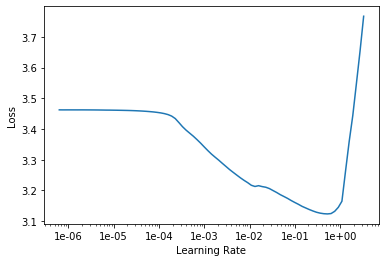

In [12]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(40, 3e-3, moms=(0.8,0.7))

In [14]:
setupLmTraining('awd_lstm','swissprotPE3AA20NoTM',lmPars,archPars,printInfo=True)

70
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(32, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(32, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=32, bias=True)
    (output_dp): RNNDropout()
  )
)


In [16]:
modelFName

'awd_lstm_swissprotPE3AA20NoTM_drop_mult_0_2'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


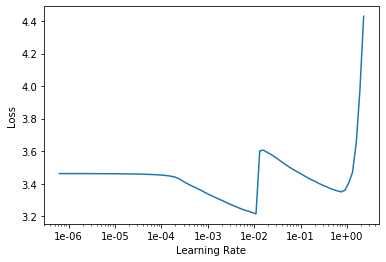

In [13]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(40, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.375439,2.337047,0.284132,42:21
1,2.118643,2.050178,0.373760,42:21
2,2.007292,1.980855,0.395250,42:27
3,2.032430,1.971479,0.398618,42:22
4,2.007107,1.959068,0.402784,42:23
5,2.020425,1.924481,0.414177,42:25
6,1.967661,1.894687,0.423810,42:24
7,1.942310,1.878101,0.428920,42:22
8,1.955570,1.868809,0.431903,42:22
9,1.901045,1.854185,0.436254,42:25


In [17]:
ulmputils.saveNextModelVersion(learn,modelFName)

In [22]:
setupLmTraining(); learn.fit(10, 5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.440791,1.417561,0.569527,42:32
1,1.471815,1.416235,0.570037,42:30
2,1.401974,1.414537,0.570445,42:29
3,1.440144,1.413482,0.570917,42:32
4,1.403215,1.412380,0.571323,42:39
5,1.445295,1.410859,0.571732,42:38
6,1.422488,1.410197,0.572002,42:41
7,1.382323,1.408958,0.572449,42:40
8,1.462061,1.408105,0.572665,42:48
9,1.397503,1.407279,0.572905,42:46


In [23]:
ulmputils.saveNextModelVersion(learn,modelFName)

In [46]:
setupLmTraining()

Loading awd_lstm_swissprotPE3AA20NoTM_drop_mult_0_2_1


In [36]:
learn.save_encoder(modelFName+'_enc')

In [15]:
# learn.load('swissp70epoch_aa20_notm_0_2dropmult_58_6acc');

In [47]:
mainModelFName = modelFName

### The obligatory cool PCA stuff:
Looking at the embedding that the language model generated for amino acids.

In [37]:
def getaaPca(learn) :
    aaEmbedding = next(learn.model[0].named_parameters())[1]
    print('embedding shape',aaEmbedding.shape)
    aaFirstPos = 9
    return aaEmbedding[aaFirstPos:aaFirstPos+20].pca(3)

#aw = learn.model[0]; aw
# weightParam = next(aw.named_parameters()); weightParam
# p = weightParam[1]; p
# p.shape
# aapca = p[9:9+20].pca(3); aapca.shape

In [38]:
aapca = getaaPca(learn)

embedding shape torch.Size([32, 400])


In [39]:
aaLetters = ulmputils.aaLetters; aaLetters, len(aaLetters)

('ACDEFGHIKLMNPQRSTVWY', 20)

In [40]:
fac0,fac1,fac2 = aapca.t()

In [41]:
sorted(list(zip(fac0,ulmputils.aaLetters)))

[(tensor(-6.1774, device='cuda:0', grad_fn=<SelectBackward>), 'F'),
 (tensor(-5.5219, device='cuda:0', grad_fn=<SelectBackward>), 'W'),
 (tensor(-5.1013, device='cuda:0', grad_fn=<SelectBackward>), 'L'),
 (tensor(-4.9717, device='cuda:0', grad_fn=<SelectBackward>), 'M'),
 (tensor(-4.8949, device='cuda:0', grad_fn=<SelectBackward>), 'I'),
 (tensor(-4.1080, device='cuda:0', grad_fn=<SelectBackward>), 'Y'),
 (tensor(-3.3976, device='cuda:0', grad_fn=<SelectBackward>), 'V'),
 (tensor(-2.3590, device='cuda:0', grad_fn=<SelectBackward>), 'C'),
 (tensor(1.0165, device='cuda:0', grad_fn=<SelectBackward>), 'H'),
 (tensor(1.2233, device='cuda:0', grad_fn=<SelectBackward>), 'T'),
 (tensor(1.9095, device='cuda:0', grad_fn=<SelectBackward>), 'A'),
 (tensor(2.2716, device='cuda:0', grad_fn=<SelectBackward>), 'P'),
 (tensor(2.3772, device='cuda:0', grad_fn=<SelectBackward>), 'R'),
 (tensor(2.9943, device='cuda:0', grad_fn=<SelectBackward>), 'Q'),
 (tensor(3.0990, device='cuda:0', grad_fn=<SelectBackw

In [42]:
def setAlpha(im) :
    height,width = im.shape[:2]
    for r in range(height) :
        for c in range(width) :
            pix = im[r,c]
            if pix[0]==1.0 and pix[1]==1.0 and pix[2]==1.0 :
                pix[3] = 0.3
            else :
                pix[3] = 1.0

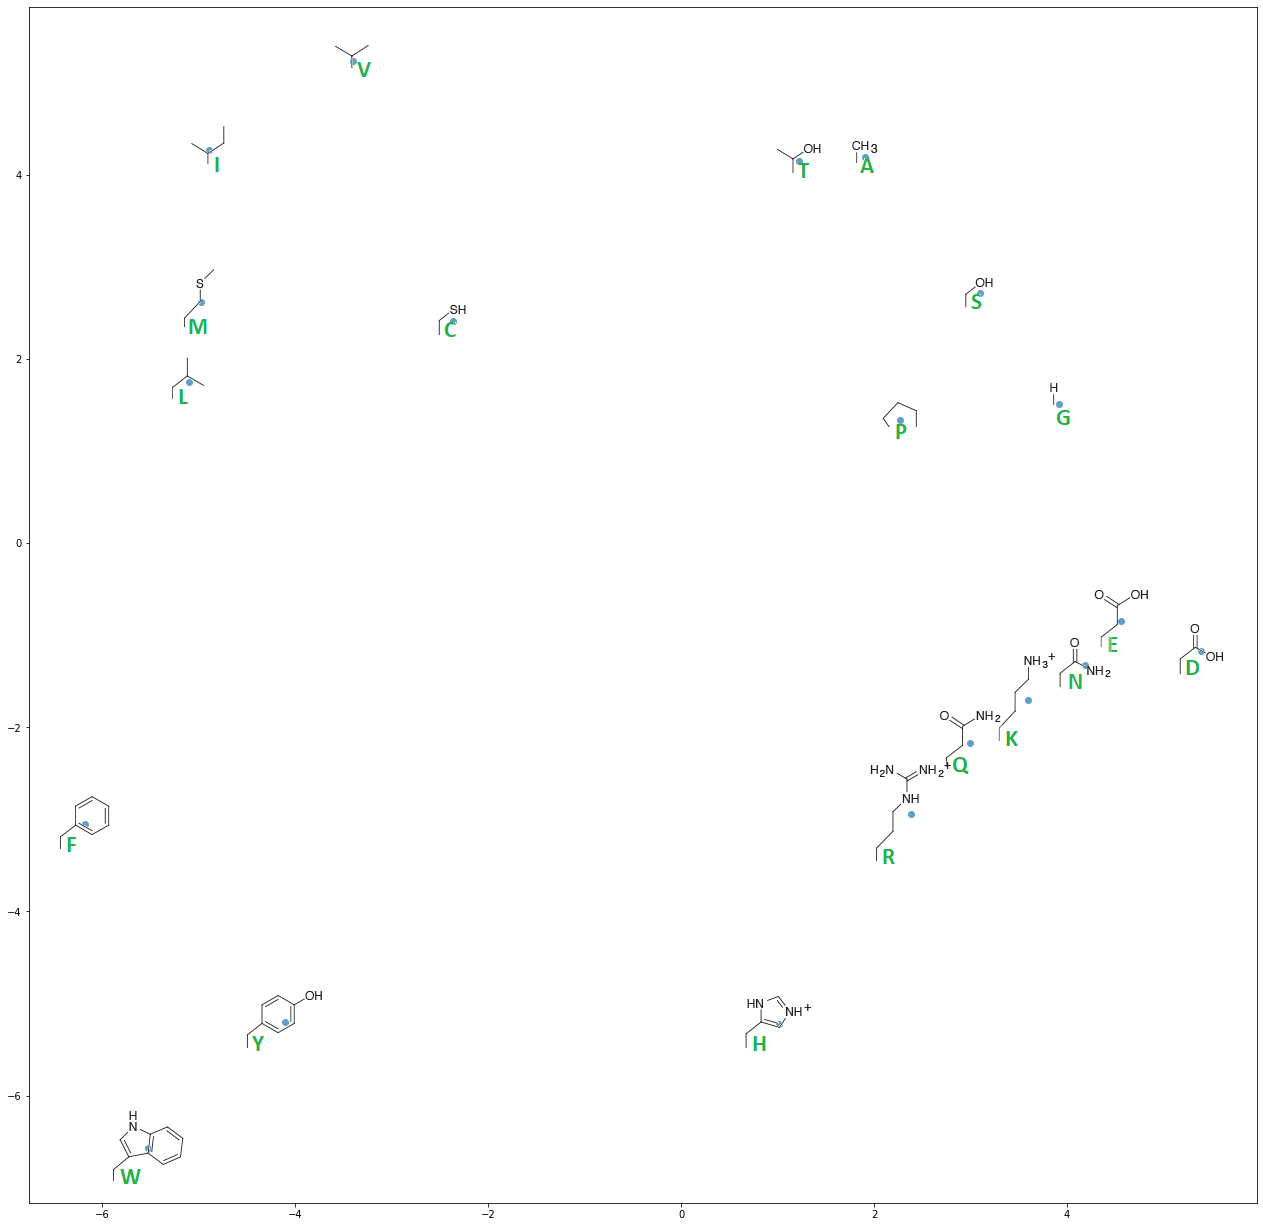

In [43]:
X,Y = fac0, fac1
plt.figure(figsize=(22,22))
ax = plt.subplot(111)
plt.scatter(X, Y)
for i, x, y in zip(aaLetters, X, Y):
    im = plt.imread('aaims/'+i+'.png')
    setAlpha(im)
    imageBox = plt.matplotlib.offsetbox.AnnotationBbox(
        plt.matplotlib.offsetbox.OffsetImage(im),
        (x,y), pad=0.0, frameon=False,
    )
    ax.add_artist(imageBox)
plt.savefig('aapca.png')
plt.show()

### Fine tuning a language model for transmembrane proteins:

In [49]:
setupLmTraining('awd_lstm','swissprotPE3AA20TM',lmPars,archPars,printInfo=True)

70
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(32, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(32, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=32, bias=True)
    (output_dp): RNNDropout()
  )
)
No version available to load!


In [50]:
ulmputils.loadLatestModelVersion(learn,mainModelFName)

Loading awd_lstm_swissprotPE3AA20NoTM_drop_mult_0_2_1


In [52]:
learn.fit_one_cycle(20, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.323240,2.343914,0.276125,06:24
1,2.079851,2.090801,0.356764,06:25
2,1.967678,1.964113,0.396288,06:23
3,1.870510,1.893539,0.419095,06:23
4,1.824809,1.841043,0.435423,06:24
5,1.780623,1.796135,0.449971,06:24
6,1.668792,1.753950,0.464244,06:24
7,1.653363,1.711153,0.476880,06:25
8,1.609042,1.669132,0.490194,06:25
9,1.518489,1.633888,0.501187,06:25


In [53]:
ulmputils.saveNextModelVersion(learn,modelFName)

Saving awd_lstm_swissprotPE3AA20TM_drop_mult_0_2


In [54]:
setupLmTraining(); learn.fit(10, 1e-4)

Loading awd_lstm_swissprotPE3AA20TM_drop_mult_0_2


epoch,train_loss,valid_loss,accuracy,time
0,1.082029,1.414488,0.573309,06:26
1,1.120964,1.411828,0.574435,06:29
2,1.125956,1.409217,0.575195,06:29
3,1.082002,1.407897,0.575873,06:27
4,1.098787,1.405039,0.576816,06:26
5,1.093351,1.404181,0.577281,06:25
6,1.023626,1.402679,0.578056,06:25
7,1.064203,1.401235,0.578753,06:25
8,1.073029,1.399163,0.579425,06:26
9,1.026038,1.397827,0.580022,06:26


In [55]:
ulmputils.saveNextModelVersion(learn,modelFName)

Saving awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_1


In [56]:
setupLmTraining(); learn.fit(20, 1e-4)

Loading awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_1


epoch,train_loss,valid_loss,accuracy,time
0,1.030358,1.398186,0.580291,06:24
1,1.071351,1.396916,0.581117,06:26
2,1.076174,1.395355,0.581593,06:24
3,1.033837,1.395394,0.582095,06:25
4,1.052443,1.392797,0.582691,06:25
5,1.046935,1.393030,0.582893,06:24
6,0.978759,1.392238,0.583401,06:25
7,1.020342,1.391714,0.583847,06:25
8,1.031128,1.389689,0.584406,06:25
9,0.985756,1.389087,0.584736,06:26


In [57]:
ulmputils.saveNextModelVersion(learn,modelFName)

Saving awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_2


In [58]:
setupLmTraining(); learn.fit(20, 1e-4)

Loading awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_2


epoch,train_loss,valid_loss,accuracy,time
0,0.976883,1.379717,0.588984,06:24
1,1.019730,1.379230,0.589529,06:25
2,1.022864,1.378335,0.589827,06:23
3,0.980982,1.379378,0.590075,06:23
4,1.001211,1.376318,0.590462,06:23
5,0.994889,1.377774,0.590670,06:23
6,0.928941,1.377223,0.590916,06:23
7,0.972021,1.377109,0.591314,06:23
8,0.983365,1.375303,0.591638,06:25
9,0.941259,1.374986,0.591824,06:23


In [59]:
ulmputils.saveNextModelVersion(learn,modelFName)

Saving awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_3


In [60]:
setupLmTraining(); learn.fit(20, 1e-4)

Loading awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_3


epoch,train_loss,valid_loss,accuracy,time
0,0.936847,1.370189,0.594518,06:24
1,0.981364,1.369805,0.595003,06:25
2,0.983368,1.369309,0.595209,06:23
3,0.941403,1.370941,0.595443,06:23
4,0.962380,1.367162,0.595617,06:24
5,0.955424,1.369782,0.595645,06:24
6,0.891342,1.368990,0.595897,06:25
7,0.935477,1.369077,0.596102,06:24
8,0.947235,1.367321,0.596399,06:25
9,0.907317,1.367399,0.596452,06:25


In [61]:
ulmputils.saveNextModelVersion(learn,modelFName)

Saving awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_4


In [64]:
setupLmTraining(); learn.fit(20, 1e-4)

Loading awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_4


epoch,train_loss,valid_loss,accuracy,time
0,0.905091,1.364804,0.598369,06:19
1,0.950954,1.364138,0.599169,06:18
2,0.952231,1.363688,0.599082,06:18
3,0.909767,1.366194,0.599158,06:18
4,0.931357,1.361632,0.599508,06:18
5,0.923965,1.365209,0.599484,06:17
6,0.861836,1.364236,0.599534,06:17
7,0.906341,1.364490,0.600046,06:17
8,0.918422,1.362616,0.600131,06:17
9,0.880375,1.363030,0.600366,06:17


In [67]:
ulmputils.saveNextModelVersion(learn,modelFName)

Saving awd_lstm_swissprotPE3AA20TM_drop_mult_0_2_5
